In [1]:
#mount
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
#pip installations
!pip install --quiet SimpleITK
!pip install --quiet seaborn
!pip install --quiet livelossplot
#!pip install --quiet torch == 1.9
!pip install --quiet ctviewer
!pip install --quiet monai

     |████████████████████████████████| 52.8 MB 201 kB/s 
     |████████████████████████████████| 1.6 MB 5.9 MB/s 
     |████████████████████████████████| 1.1 MB 34.8 MB/s 


In [3]:
#imports
import monai

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
import seaborn as sns
import pandas as pd

import torch
import os
import sklearn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from livelossplot import PlotLosses
import torch.nn as nn
import json
import datetime
from datetime import datetime
from sklearn.metrics import confusion_matrix
import torchvision
import random
from ctviewer import CTViewer

#Dice Loss used for criterion
import torch
import torch.nn as nn
import torch.functional as f
import numpy as np

#device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

#copy from github
!git clone https://github.com/kilgore92/PyTorch-UNet.git
%cd PyTorch-UNet
%cd src
from unet.model import UNet
%cd ..
%cd ..

#set the Dice Loss for model learning
#from keras import backend as K
#from tensorflow.compat.v1 import enable_eager_execution
#import tensorflow as tf

cuda
Cloning into 'PyTorch-UNet'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 213 (delta 21), reused 37 (delta 12), pack-reused 165
Receiving objects: 100% (213/213), 43.46 KiB | 10.86 MiB/s, done.
Resolving deltas: 100% (94/94), done.
/content/PyTorch-UNet
/content/PyTorch-UNet/src
/content/PyTorch-UNet
/content


In [67]:
#Dataset
class CustomImageDataset(Dataset):
    def __init__(self, df, cta_label, gt_label, aug = False, binarize = False):
        self.df = df
        self.len = len(df)
        self.aug = aug
        self.cta_label = cta_label
        self.gt_label = gt_label
        self.binarize = binarize

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
      row = self.df.iloc[idx]
      image = sitk.GetArrayFromImage(sitk.ReadImage(row[self.cta_label]))
      label = sitk.GetArrayFromImage(sitk.ReadImage(row[self.gt_label]))
      image = np.expand_dims(image, axis = (0))
      label = np.expand_dims(label, axis = (0))
      image = torch.Tensor(image)
      label = torch.Tensor(label)

      #binarize for the firt stage (could have implemented for the previous models, AAA-DICOM)
      if self.binarize:
        label = torch.where(label >= 1, 1, 0)

      #augmentation
      if self.aug:
        if random.random() > 0.5:
          #horizontal
          image = torchvision.transforms.functional.hflip(image)
          label = torchvision.transforms.functional.hflip(label)
        if random.random() > 0.5:
          #vertical
          image = torchvision.transforms.functional.vflip(image)
          label = torchvision.transforms.functional.vflip(label)
        if random.random() > 0.5:
          #rotate
          angle = random.choice([30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330])
          image = torchvision.transforms.functional.rotate(image, angle)
          label = torchvision.transforms.functional.rotate(label, angle)
        #noise
        if random.random() > 0.5:
          noise = torch.normal(random.uniform(-0.9, 0.9), random.uniform(0.01, 0.1), image.shape)
          image = image + noise
        #alternate rotations about the axis
        if random.random() > 0.25:
          ls = random.sample([1,2,3], 2)
          k = random.randint(1, 3)
          image = torch.rot90(image, k, ls)
          label = torch.rot90(label, k, ls)

      #return
      return image, label

#get the optimizer and scheduler
def get_opt_sch(model, train_params):
  #AdamW
  if train_params['optimizer'] == 'AdamW':
    #optimizer 
    optimizer = torch.optim.AdamW(model.parameters(), lr = train_params['lr'], weight_decay = train_params['weight_decay'])

  #Adam
  if train_params['optimizer'] == 'Adam':
    #optimizer 
    optimizer = torch.optim.Adam(model.parameters(), lr = train_params['lr'], weight_decay = train_params['weight_decay'])

  #NAdam
  if train_params['optimizer'] == 'NAdam':
    #optimizer 
    optimizer = torch.optim.NAdam(model.parameters(), lr = train_params['lr'], weight_decay = train_params['weight_decay'])

  #RAdam
  if train_params['optimizer'] == 'RAdam':
    #optimizer 
    optimizer = torch.optim.RAdam(model.parameters(), lr = train_params['lr'], weight_decay = train_params['weight_decay'])

  #scheduler (intutively modify the learning rate)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode = 'min', 
                                                       factor = train_params['factor'], 
                                                       patience = train_params['patience'], 
                                                       threshold = train_params['threshold'], 
                                                       threshold_mode = 'rel', 
                                                       cooldown = 0, 
                                                       min_lr = 0, 
                                                       eps = 1, 
                                                       verbose = True)
  
  #return
  return optimizer, scheduler

class DICELoss(nn.Module):
      def __init__(self, weight=None, size_average=True):
          super(DICELoss, self).__init__()

      def forward(self, output, mask, eps=1e-8):
          """
          The output layer of Kilgore's 3D-UNet implementation is a LeakyReLU.
          We need to apply a sigmoid activation to the model output in order to
          constrain the target value between 0 and 1.
          See source code (Line 243):
          https://github.com/kilgore92/PyTorch-UNet/blob/master/src/unet/blocks.py#L243
          """

          output = torch.sigmoid(output)
          
          output = output.view(-1)
          mask = mask.view(-1)
          
          intersection = (output * mask).sum()                            
          dice_coeff = (2.*intersection + eps)/(output.sum() + mask.sum() + eps)  

          dice_loss = 1 - dice_coeff

          return dice_loss

#save json file
def save_params(hyper_params, save_path):
  json_string = json.dumps(hyper_params)
  with open(save_path, 'w') as outfile:
    outfile.write(json_string)

#load the train params back in
def load_params(fpath):
  # Opening JSON file
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

#load a pretrained model
def load_pretrained_model(save_folder, device):
  train_params = load_params(save_folder + 'train_params.json')
  model = torch.load(train_params['save_path'] + 'model.pth')
  model.to(device)
  return train_params, model

#save image
def save_image(save_path, save_folder, patient, image):
  #save file
  if os.path.isdir(save_path + save_folder) == False:
    os.mkdir(save_path + save_folder)
  #save file
  save_loc = save_path + save_folder + '/' + patient + '.nii.gz'
  #write
  sitk.WriteImage(image, save_loc)
  #return
  return save_loc

#localized prediction inference
def localized_predictions_inference(row, train_params, model, resampler, otsu, device):
  #read in the CTA-64 model
  orig_image = sitk.ReadImage(row['Norm-CTA'])
  image = sitk.ReadImage(row['Norm-CTA-64'])
  #already normalized
  x = torch.Tensor(np.expand_dims(sitk.GetArrayFromImage(image), axis = (0, 1))).to(device)
  #pass
  model.eval()
  with torch.no_grad():
    y_pred = model(x)
  #convert back
  prediction = sitk.GetImageFromArray(np.squeeze(torch.sigmoid(y_pred).cpu().detach().numpy()))
  #reset to the og
  prediction.CopyInformation(image)
  #upsample to the original
  resampler.SetReferenceImage(orig_image)
  resampler.SetTransform(sitk.Transform())
  resampler.SetInterpolator(sitk.sitkNearestNeighbor)
  #resampler.SetInterpolator(sitk.sitkBSpline)
  prediction = resampler.Execute(prediction)
  prediction.CopyInformation(orig_image)
  #otsu threshold
  otsu.SetOutsideValue(1)
  otsu.SetInsideValue(0)
  prediction = otsu.Execute(prediction)

  #save info somewhere
  return save_image(train_params['save_path'], 'localized-predictions', row['Patient'], prediction)

#image resampling
def resample_image_standardize(itk_image, out_size = (64,64,64), is_label = False):
  original_spacing = itk_image.GetSpacing()
  original_size = itk_image.GetSize()
  out_spacing = [original_size[0] * (original_spacing[0] / out_size[0]),
                 original_size[1] * (original_spacing[1] / out_size[1]),
                 original_size[2] * (original_spacing[2] / out_size[2])]

  resample = sitk.ResampleImageFilter()
  resample.SetOutputSpacing(out_spacing)
  resample.SetOutputOrigin(itk_image.GetOrigin())
  resample.SetSize(out_size)
  resample.SetOutputDirection(itk_image.GetDirection())
  resample.SetTransform(sitk.Transform())
  #resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
  if is_label:
      resample.SetInterpolator(sitk.sitkNearestNeighbor)
  else:
      resample.SetInterpolator(sitk.sitkBSpline)
  return resample.Execute(itk_image)

#generate a binary mask
def binarize(lower, upper, image, binary_filter):
  binary_filter.SetLowerThreshold(lower)
  binary_filter.SetUpperThreshold(upper)
  return binary_filter.Execute(image)

#high res segmentation
def high_res_predictions_inference(row, train_params, model, resampler, binary, device):
  #read in the CTA-64
  orig_image = sitk.ReadImage(row['Norm-CTA'])
  localized_prediction = sitk.ReadImage(row['localized-predictions'])
  #apply #the bounding box to the CTA
  #filter
  label_shape_filter = sitk.LabelShapeStatisticsImageFilter()
  #apply
  label_shape_filter.Execute(localized_prediction)
  #get bbox
  bbox = label_shape_filter.GetBoundingBox(1) #in pixel coordinates
  #get ROI
  ROI_image = sitk.RegionOfInterest(orig_image, bbox[int(len(bbox)/2):], bbox[0:int(len(bbox)/2)])
  #resample the CTA
  ROI_image_64 = resample_image_standardize(ROI_image, out_size = (64, 64, 64), is_label = False)
  #z-norm the CTA
  z = sitk.NormalizeImageFilter()
  ROI_image_64 = z.Execute(ROI_image_64)
  #pass
  x = torch.Tensor(np.expand_dims(sitk.GetArrayFromImage(ROI_image_64), axis = (0, 1))).to(device)
  #pass
  model.eval()
  #no grad
  with torch.no_grad():
    y_pred = model(x)
    #save
    x = None
  #get y pred
  y_pred = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
  #convert back
  prediction = sitk.GetImageFromArray(np.squeeze(y_pred.cpu().detach().numpy()))
  #save
  y_pred = None
  #reset to the og
  prediction.CopyInformation(ROI_image_64)
  #upsample to the original
  resampler.SetReferenceImage(ROI_image)
  resampler.SetTransform(sitk.Transform())
  #resampler.SetInterpolator(sitk.sitkBSpline)
  resampler.SetInterpolator(sitk.sitkNearestNeighbor)
  prediction = resampler.Execute(prediction)
  prediction.CopyInformation(ROI_image)
  #perform otsu thresholding here
  binary.SetUpperThreshold(1)
  binary.SetLowerThreshold(1)
  prediction = binary.Execute(prediction)
  #insert back into the original frame of reference
  blank_image = sitk.Image(orig_image.GetSize(), sitk.sitkUInt8)
  #insert the high resolution segmentation into the original CTA
  pred_origin = orig_image.TransformPhysicalPointToContinuousIndex(prediction.GetOrigin())
  #bounds
  pred_bounds = prediction.GetSize()
  #insert
  try:
    blank_image[
        int(pred_origin[0]):int(pred_origin[0] + pred_bounds[0]), 
        int(pred_origin[1]):int(pred_origin[1] + pred_bounds[1]), 
        int(pred_origin[2]):int(pred_origin[2] + pred_bounds[2])
        ] = prediction
  except:
    #safeguard (use try and except and else)
    blank_image[
        int(pred_origin[0]):(int(pred_origin[0]) + int(pred_bounds[0])),
        int(pred_origin[1]):(int(pred_origin[1]) + int(pred_bounds[1])),
        int(pred_origin[2]):(int(pred_origin[2]) + int(pred_bounds[2]))
        ] = prediction
  #copy
  blank_image.CopyInformation(orig_image)
  #smooth = sitk.BinaryMedianImageFilter()
  #smooth.GetBackgroundValue(0)
  #smooth.GetForegroundValue(1)
  #smooth.SetBackgroundValue(0)
  #smooth.SetForegroundValue(1)
  #save
  return save_image(train_params['save_path'], 'high-res-predictions', row['Patient'], blank_image)

#perform DSC score evaluation
def compute_metrics(gt, pred, metrics = sitk.LabelOverlapMeasuresImageFilter()):
  #compare
  metrics.Execute(gt, pred)
  DSC = metrics.GetDiceCoefficient()
  FP = metrics.GetFalsePositiveError()
  FN = metrics.GetFalseNegativeError()
  JC = metrics.GetJaccardCoefficient()
  #gt
  #pred
  return DSC, FP, FN, JC

#get
def get_metrics(row, gt_col = 'Mask-Wall', pred_col = 'high-res-predictions'):
  #read
  gt = sitk.ReadImage(row[gt_col])
  pred = sitk.ReadImage(row[pred_col])
  return compute_metrics(gt, pred)

#visualize one specific image (cannot superimpose mask as of yet)
def visualize_specific_image(row, im_type):
  image = sitk.GetArrayFromImage(sitk.ReadImage(row[im_type]))
  CTViewer(image)
  plt.show()

def get_loss_func(train_params):
  #generalized dice loss
  if train_params['loss'] == 'GDL':
    loss = monai.losses.GeneralizedDiceLoss(include_background = True, softmax = True, to_onehot_y = True)
  #original DiceLoss
  if train_params['loss'] == 'DICELoss':
    loss = DICELoss()
  #masked dice loss - the contribution is specific to the mask! could try variant with softmax binary class activation
  if train_params['loss'] == 'MDL':
    loss = monai.losses.MaskedDiceLoss(include_background = False, sigmoid = True)
  #all of the above
  if train_params['loss'] == 'GDFL':
    loss = monai.losses.GeneralizedDiceFocalLoss(include_background = True, softmax = True, to_onehot_y = True, focal_weight = [0.01, 0.65, 0.24, 0.1])
  #return
  return loss

In [ ]:
#read in the saved pickle file
data_path = '/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/data/3D/data_filter_status_split.pkl'
df = pd.read_pickle(data_path)

In [ ]:
#first part is the localizer

#save folder
save_folder = '/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/results/3D-BB-AAA-UNet-Filter-Status-results/'
#specify a save location
folder = datetime.now().strftime("localizer-%Y-%m-%d-%H-%M") + '/'
#the save path for everything
save_path = save_folder + folder
if os.path.isdir(save_path) == False:
  os.mkdir(save_path)

In [ ]:
#specify the model params
model_params = {}

#specify the type of model and its correspnding parameters
model_params = {
    'type': 'OG_Unet' #modify this to change the type and the later entries to change parameter settings
}

#aux params (classification)?
#aux_params = {
#    'classes': None,
#    'pooling': 'avg',
#    'dropout': 0,
#    'activation': None
#    }

#og_unet
if model_params['type'] == 'OG_Unet':
  model_params['n_channels'] = 1
  model_params['base_filter_num'] = 64
  model_params['num_blocks'] = 4
  model_params['num_classes'] = 1
  model_params['mode'] = '3D'
  model_params['dropout'] = False
  model_params['dropout_rate'] = 0.2
  model_params['use_pooling'] = True #dpes this make differnece?
  #define the model
  model = UNet(model_params['n_channels'], model_params['base_filter_num'], model_params['num_blocks'], model_params['num_classes'], model_params['mode'], model_params['dropout'],
               model_params['dropout_rate'], model_params['use_pooling'])

In [ ]:
#init
train_params = {}
#training parameters
train_params = {
    'batch_size': 1, #try to keep high as possible/increases stability
    'lr': 1e-4, #could try 1e-3 or 1e-5 ?
    'optimizer': 'AdamW',
    'weight_decay': 1e-2,
    'factor': 1e-1,
    'patience': 2, #1
    'threshold': 1e-3, #might need to increase this
    'epochs': 75,#60 epochs would suffice!
    'loss': 'DICELoss', 
    'model_params': model_params,
    'aug': True,
    'save_path': save_path, 
    'epochs_trained': 0,
    'model_type': 'localizer',
    'data': data_path
}

In [ ]:
#obtain the training data
dset_train = CustomImageDataset(df[df['DATA'] == 'TRAIN'], cta_label = 'Norm-CTA-64', gt_label = 'Mask-All-64', 
                                aug = train_params['aug'], binarize = True)
train_loader = DataLoader(dset_train, batch_size = train_params['batch_size'])
#obtain the validation data (or test in this case)
dset_test = CustomImageDataset(df[df['DATA'] == 'TEST'], cta_label = 'Norm-CTA-64', gt_label = 'Mask-All-64', 
                               aug = False, binarize = True)
test_loader = DataLoader(dset_test, batch_size = train_params['batch_size'])
#send to device
model.to(device)
#get the optimizer and scheduler
optimizer, scheduler = get_opt_sch(model, train_params)
#get the loss
criterion = get_loss_func(train_params)

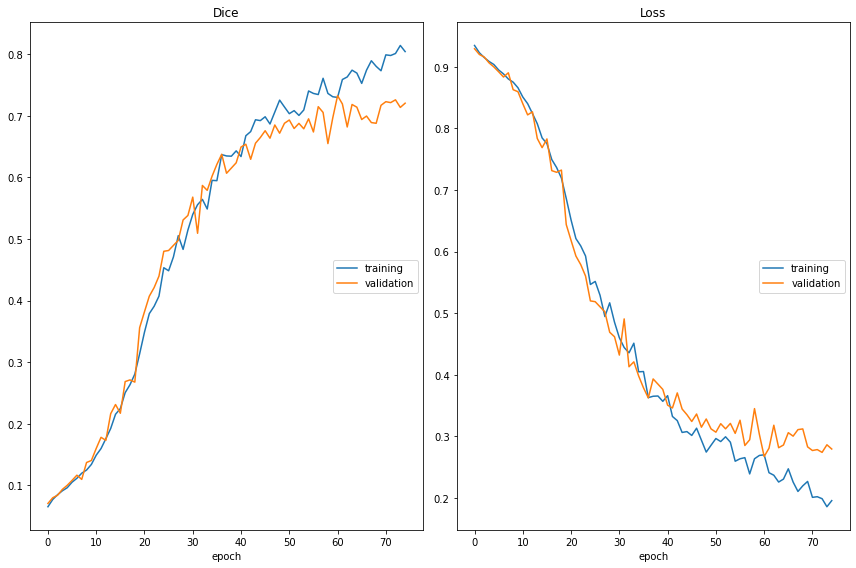

Dice
	training         	 (min:    0.065, max:    0.814, cur:    0.804)
	validation       	 (min:    0.070, max:    0.733, cur:    0.721)
Loss
	training         	 (min:    0.186, max:    0.935, cur:    0.196)
	validation       	 (min:    0.267, max:    0.930, cur:    0.279)
CPU times: user 2h 29min 36s, sys: 1min 37s, total: 2h 31min 13s
Wall time: 2h 40min 5s


In [ ]:
%%time
#plotting in Jupyter Notebook 11 min for firts epoch 
liveloss = PlotLosses()
#logs
logs = {}
#iterate epochs
for epoch in range(train_params['epochs_trained'] + 1, train_params['epochs'] + 1):
  #determine losses
  train_epoch_loss = 0
  val_epoch_loss = 0
  #specify training
  model.train()
  #iterate through the training data
  for i, (x, y_true) in enumerate(train_loader):
    #zero optimizers
    optimizer.zero_grad()
    #send to GPU
    x = x.to(device)
    y_true = y_true.to(device)
    #predict
    y_pred = model(x)
    #determine loss (should already be averaged)
    loss = criterion(y_pred, y_true)
    #backward
    loss.backward()
    #step
    optimizer.step()
    #track the loss
    train_epoch_loss = train_epoch_loss + loss.item() #/ train_params['batch_size']
    #break
    #if i > 1:
      #break
  #specify eval
  model.eval()
  #set
  with torch.no_grad():
    #iterate through the testing data
    for i, (x, y_true) in enumerate(test_loader):
      #send to GPU
      x = x.to(device)
      y_true = y_true.to(device)
      #predict
      y_pred = model(x)
      #determine loss
      loss = criterion(y_pred, y_true)
      #track the loss (shoudld already be averaged)
      val_epoch_loss = val_epoch_loss + loss.item() #/ train_params['batch_size']
      #break
      #if i > 1:
        #break

  #specify the logs
  prefix = ''
  logs['Loss'] = train_epoch_loss / len(train_loader)
  logs['Dice'] = 1 - train_epoch_loss / len(train_loader)

  prefix = 'val_'
  logs[prefix + 'Loss'] = val_epoch_loss / len(test_loader)
  logs[prefix + 'Dice'] = 1- val_epoch_loss / len(test_loader)
  #living loss
  liveloss.update(logs)
  #send
  liveloss.send()
  #the scheduler (the way the loss is calculated must be correct for correct scheduling!)
  scheduler.step(train_epoch_loss)
  #save the model every 5 epochs 
  if (epoch % 5 == 0) and (epoch != 0):
    torch.save(model, train_params['save_path'] + 'model.pth')
    #keep track of training
    train_params['epochs_trained'] = 5 + train_params['epochs_trained']
    #save the number of epochs in case model stops training
    save_params(train_params, train_params['save_path'] + 'train_params.json')

In [ ]:
#need to set up the second model (assuming the first has been saved)
model = None
#specify the data path (should be the same as the one above)
data_path = '/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/data/3D/data_filter_status_split.pkl'
#read in the saved pickle file
df = pd.read_pickle(data_path)

In [ ]:
#save folder
save_folder = '/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/results/3D-BB-AAA-UNet-Filter-Status-results/'
#specify a save location
folder = datetime.now().strftime("high-res-segmentation-%Y-%m-%d-%H-%M") + '/'
#the save path for everything
save_path = save_folder + folder
if os.path.isdir(save_path) == False:
  os.mkdir(save_path)

In [ ]:
#specify the model params
model_params = {}

#specify the type of model and its correspnding parameters
model_params = {
    'type': 'OG_Unet' #modify this to change the type and the later entries to change parameter settings
}

#aux params (classification)?
#aux_params = {
#    'classes': None,
#    'pooling': 'avg',
#    'dropout': 0,
#    'activation': None
#    }

#og_unet
if model_params['type'] == 'OG_Unet':
  model_params['n_channels'] = 1
  model_params['base_filter_num'] = 64
  model_params['num_blocks'] = 4
  model_params['num_classes'] = 4
  model_params['mode'] = '3D'
  model_params['dropout'] = False
  model_params['dropout_rate'] = 0.2 #0 when implemented
  model_params['use_pooling'] = True
  #define the model
  model = UNet(model_params['n_channels'], model_params['base_filter_num'], model_params['num_blocks'], model_params['num_classes'], model_params['mode'], model_params['dropout'],
               model_params['dropout_rate'], model_params['use_pooling'])

In [ ]:
#init
train_params = {}
#training parameters
train_params = {
    'batch_size': 1, #try to keep high as possible/increases stability
    'lr': 1e-4,
    'optimizer': 'AdamW',
    'weight_decay': 1e-2,
    'factor': 1e-1,
    'patience': 2, #1
    'threshold': 1e-3,
    'epochs': 55,
    'loss': 'GDL', 
    'model_params': model_params,
    'aug': True,
    'save_path': save_path, 
    'epochs_trained': 0,
    'model_type': 'multiclass segmentation',
    'data': data_path
}

In [ ]:
#obtain the training data
dset_train = CustomImageDataset(df[df['DATA'] == 'TRAIN'], cta_label = 'Norm-CTA-Cropped-64', gt_label = 'Mask-All-Cropped-64', aug = train_params['aug'], binarize = False)
train_loader = DataLoader(dset_train, batch_size = train_params['batch_size'])
#obtain the validation data (or test in this case)
dset_test = CustomImageDataset(df[df['DATA'] == 'TEST'], cta_label = 'Norm-CTA-Cropped-64', gt_label = 'Mask-All-Cropped-64', aug = False, binarize = False)
test_loader = DataLoader(dset_test, batch_size = train_params['batch_size'])
#send to device
model.to(device)
#get the optimizer and scheduler
optimizer, scheduler = get_opt_sch(model, train_params)
#get the loss
criterion = get_loss_func(train_params)

In [ ]:
#can reset train params to continue training (in the same run)
train_params['epochs'] = 100

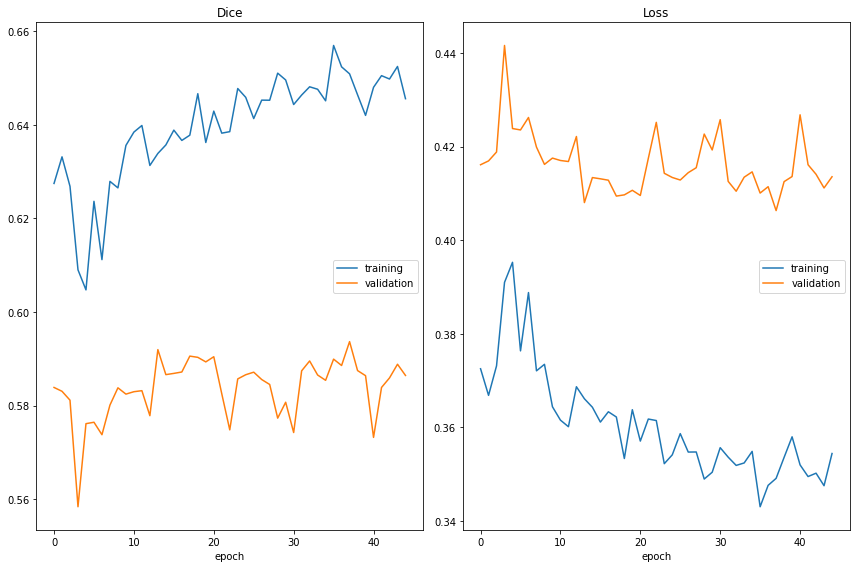

Dice
	training         	 (min:    0.605, max:    0.657, cur:    0.646)
	validation       	 (min:    0.558, max:    0.594, cur:    0.586)
Loss
	training         	 (min:    0.343, max:    0.395, cur:    0.354)
	validation       	 (min:    0.406, max:    0.442, cur:    0.414)
CPU times: user 1h 27min 38s, sys: 58 s, total: 1h 28min 36s
Wall time: 1h 31min 24s


In [ ]:
%%time
#plotting in Jupyter Notebook
liveloss = PlotLosses()
#logs
logs = {}
#iterate epochs
for epoch in range(train_params['epochs_trained'] + 1, train_params['epochs'] + 1):
  #determine losses
  train_epoch_loss = 0
  val_epoch_loss = 0
  #specify training
  model.train()
  #iterate through the training data
  for i, (x, y_true) in enumerate(train_loader):
    #zero optimizers
    optimizer.zero_grad()
    #send to GPU
    x = x.to(device)
    y_true = y_true.to(device)
    #predict
    y_pred = model(x)
    #determine loss (should already be averaged)
    loss = criterion(y_pred, y_true)
    #backward
    loss.backward()
    #step
    optimizer.step()
    #track the loss
    train_epoch_loss = train_epoch_loss + loss.item() #/ train_params['batch_size']
    #break
    #if i > 1:
      #break
  #specify eval
  model.eval()
  #set
  with torch.no_grad():
    #iterate through the testing data
    for i, (x, y_true) in enumerate(test_loader):
      #send to GPU
      x = x.to(device)
      y_true = y_true.to(device)
      #predict
      y_pred = model(x)
      #determine loss
      loss = criterion(y_pred, y_true)
      #track the loss (shoudld already be averaged)
      val_epoch_loss = val_epoch_loss + loss.item() #/ train_params['batch_size']
      #break
      #if i > 1:
        #break

  #specify the logs
  prefix = ''
  logs['Loss'] = train_epoch_loss / len(train_loader)
  logs['Dice'] = 1 - train_epoch_loss / len(train_loader)

  prefix = 'val_'
  logs[prefix + 'Loss'] = val_epoch_loss / len(test_loader)
  logs[prefix + 'Dice'] = 1- val_epoch_loss / len(test_loader)
  #living loss
  liveloss.update(logs)
  #send
  liveloss.send()
  #the scheduler (the way the loss is calculated must be correct for correct scheduling!)
  scheduler.step(train_epoch_loss)
  #save the model every 5 epochs 
  if (epoch % 5 == 0) and (epoch != 0):
    torch.save(model, train_params['save_path'] + 'model.pth')
    #keep track of training
    train_params['epochs_trained'] = 5 + train_params['epochs_trained']
    #save the number of epochs in case model stops training
    save_params(train_params, train_params['save_path'] + 'train_params.json')

In [57]:
#do the inference for the models to evaluate all the results
data_path = '/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/data/3D/data_filter_status_split.pkl'
#read in the saved pickle file
df = pd.read_pickle(data_path)

In [74]:
#load the trained localizer model
model = None
train_params, model = load_pretrained_model('/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/results/3D-BB-AAA-UNet-Filter-Status-results/localizer-2022-10-26-12-37/', device)

In [75]:
%%time
#init 15 min
resampler = sitk.ResampleImageFilter()
otsu = sitk.OtsuThresholdImageFilter()

#apply
df['localized-predictions'] = df.apply(localized_predictions_inference, axis = 1, args = (train_params, model, resampler, otsu, device))

CPU times: user 1min 47s, sys: 2.7 s, total: 1min 49s
Wall time: 1min 28s


In [76]:
#need to save which localizer was used 
localizer = train_params['save_path']

In [77]:
#load the trained high res segmentation model
model = None
train_params, model = load_pretrained_model('/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/results/3D-BB-AAA-UNet-Filter-Status-results/high-res-segmentation-2022-10-26-18-02/', device)
#train_params['localizer'] = localizer

In [78]:
%%time
#init
resampler = sitk.ResampleImageFilter()
binary = sitk.BinaryThresholdImageFilter()

#apply
df['high-res-predictions'] = df.apply(high_res_predictions_inference, axis = 1, args = (train_params, model, resampler, binary, device))

CPU times: user 1min 11s, sys: 1.88 s, total: 1min 13s
Wall time: 1min 10s


In [79]:
%%time
#apply
df['DSC'], df['FP'], df['FN'], df['JC'] = zip(*df.apply(get_metrics, axis = 1))
#save
df.to_pickle(train_params['save_path'] + 'df_results.pkl')
#save the params
save_params(train_params, train_params['save_path'] + 'train_params.json')

CPU times: user 24.3 s, sys: 621 ms, total: 25 s
Wall time: 16.5 s


In [82]:
df[df['DATA'] == 'TRAIN']['DSC'].describe()

count    36.000000
mean      0.443253
std       0.108059
min       0.076096
25%       0.384877
50%       0.443493
75%       0.524664
max       0.609249
Name: DSC, dtype: float64

In [83]:
df[df['DATA'] == 'TEST']['DSC'].describe()

count    30.000000
mean      0.355792
std       0.159128
min       0.003655
25%       0.262826
50%       0.390956
75%       0.481016
max       0.565187
Name: DSC, dtype: float64

In [ ]:
df[df['DATA'] == 'TRAIN']['DSC'].describe()

count    73.000000
mean      0.412021
std       0.147351
min       0.037842
25%       0.331686
50%       0.443730
75%       0.507414
max       0.628371
Name: DSC, dtype: float64

In [ ]:
df[df['DATA'] == 'TEST']['DSC'].describe()

count    50.000000
mean      0.378329
std       0.167184
min       0.040621
25%       0.241085
50%       0.428582
75%       0.509577
max       0.634607
Name: DSC, dtype: float64

In [ ]:
df[(df['DATA'] == 'TRAIN') & (df['Class'] == 'Asymptomatic')]['DSC'].describe()

count    38.000000
mean      0.400598
std       0.136787
min       0.037842
25%       0.312839
50%       0.401536
75%       0.488203
max       0.628371
Name: DSC, dtype: float64

In [ ]:
df[(df['DATA'] == 'TEST') & (df['Class'] == 'Asymptomatic')]['DSC'].describe()

count    25.000000
mean      0.331554
std       0.166382
min       0.040621
25%       0.226346
50%       0.328995
75%       0.475464
max       0.602303
Name: DSC, dtype: float64

In [ ]:
df[(df['DATA'] == 'TEST') & (df['Class'] == 'Symptomatic')]['DSC'].describe()

count    25.000000
mean      0.425104
std       0.157558
min       0.093580
25%       0.327155
50%       0.471246
75%       0.545780
max       0.634607
Name: DSC, dtype: float64

In [ ]:
df[(df['DATA'] == 'TRAIN') & (df['Class'] == 'Symptomatic')]['DSC'].describe()

count    35.000000
mean      0.424423
std       0.159102
min       0.049959
25%       0.372645
50%       0.466324
75%       0.520139
max       0.627623
Name: DSC, dtype: float64

In [ ]:
df[df['DATA'] == 'TEST'].iloc[0]

Class                                                         Asymptomatic
Class_Label                                                              0
Wall                                                                    NA
Wall_Label                                                               0
Patient                                                              GU003
Norm-CTA                 /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-Wall                /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-ILT                 /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-AAA                 /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-All                 /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Norm-CTA-64              /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-Wall-64             /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-ILT-64              /content/gdrive/MyDrive/AAA_Project/Masters-Th...
Mask-AAA-64              

In [ ]:
df[df['DATA'] == 'TEST']['DSC'].describe()

count    50.000000
mean      0.378329
std       0.167184
min       0.040621
25%       0.241085
50%       0.428582
75%       0.509577
max       0.634607
Name: DSC, dtype: float64

In [ ]:
df[df['DATA'] == 'TRAIN']['DSC'].describe()

count    73.000000
mean      0.412021
std       0.147351
min       0.037842
25%       0.331686
50%       0.443730
75%       0.507414
max       0.628371
Name: DSC, dtype: float64

In [ ]:
#visualize
row = df[df['DATA'] == 'TEST'].iloc[2]
im_type = 'CTA'
visualize_specific_image(row, im_type)

interactive(children=(RadioButtons(description='Slice plane selection:', index=2, options=('y-z', 'z-x', 'x-y'…